# Implementation of $[[n, k, d]]$ codes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, Statevector, Kraus, SuperOp
from qiskit.quantum_info import hellinger_fidelity, state_fidelity
from qiskit_ibm_provider import IBMProvider, least_busy

from qiskit.result import marginal_counts
from qiskit.tools.monitor import job_monitor

In [2]:
np.random.seed(400)

#### $[[7, 1, 3]]$ code 

Stabilizers - 

$I I I X X X X, I X X I I X X, X I X I X I X, I I I Z Z Z Z, I Z Z I I Z Z, Z I Z I Z I Z$

In [3]:
qdata_register = QuantumRegister(7, name="data")
stabilizer_measure_reg = QuantumRegister(6, name="anc")
bit_syndrome_measure = ClassicalRegister(3, name="bit_syn")
phase_syndrome_measure = ClassicalRegister(3, name="phase_syn")
cdata_register = ClassicalRegister(7, name="readout")

state_register = qdata_register[0]
encoding_register = qdata_register[1:]

In [4]:
def initialize_qubits(circuit: QuantumCircuit, state_reg: QuantumRegister) -> QuantumCircuit:
    ''' Initialize qubit in a particular state '''
    circuit.x(state_reg)
    # circuit.h(state_reg)

    circuit.barrier(state_reg)
    return circuit

def encoding() -> QuantumCircuit:
    ''' Encoding for $$[[7, 1, 3]]$$ code'''
    
    circuit = QuantumCircuit(7, name="    Encoding    ")

    circuit.h([4, 5, 6])

    circuit.cx(0, 1)
    circuit.cx(0, 2)

    circuit.cx(6, 3)
    circuit.cx(6, 1)
    circuit.cx(6, 0)

    circuit.cx(5, 3)
    circuit.cx(5, 2)
    circuit.cx(5, 0)

    circuit.cx(4, 3)
    circuit.cx(4, 2)
    circuit.cx(4, 1)
    
    return circuit

def fake_noise(circuit: QuantumCircuit, qdata_reg: QuantumCircuit, distance: int, noise_type: str, noisy_qubits) -> QuantumCircuit:
    ''' Applies noise_type (either 'X' or 'Z' or 'XZ') on random 
    qubits in qdata_reg based on the distance of the code'''
    for qubit in noisy_qubits:
        if noise_type[0] == 'X':
            circuit.x(qdata_reg[qubit])
        if noise_type[-1] == 'Z':
            circuit.z(qdata_reg[qubit])
    return circuit

def stabilizer_measurement() -> QuantumCircuit:
    ''' Measure the stabilizers using stab_meas and store the 
    error syndrome in syndrome_reg. Once the syndrome is saved, 
    reset the stab_meas qubits'''
    
    data_qubits = QuantumRegister(7)
    ancilla_qubits = QuantumRegister(6)
    bit_register = ClassicalRegister(3)
    phase_register = ClassicalRegister(3)

    circuit = QuantumCircuit(data_qubits, ancilla_qubits, bit_register, phase_register)

    circuit.cx(data_qubits[0], ancilla_qubits[0])
    circuit.cx(data_qubits[2], ancilla_qubits[0])
    circuit.cx(data_qubits[4], ancilla_qubits[0])
    circuit.cx(data_qubits[6], ancilla_qubits[0])

    circuit.cx(data_qubits[1], ancilla_qubits[1])
    circuit.cx(data_qubits[2], ancilla_qubits[1])
    circuit.cx(data_qubits[5], ancilla_qubits[1])
    circuit.cx(data_qubits[6], ancilla_qubits[1])

    circuit.cx(data_qubits[3], ancilla_qubits[2])
    circuit.cx(data_qubits[4], ancilla_qubits[2])
    circuit.cx(data_qubits[5], ancilla_qubits[2])
    circuit.cx(data_qubits[6], ancilla_qubits[2])

    # circuit.barrier()

    circuit.h(ancilla_qubits[3:])

    circuit.cx(ancilla_qubits[3], data_qubits[6])
    circuit.cx(ancilla_qubits[3], data_qubits[4])
    circuit.cx(ancilla_qubits[3], data_qubits[2])
    circuit.cx(ancilla_qubits[3], data_qubits[0])

    circuit.cx(ancilla_qubits[4], data_qubits[6])
    circuit.cx(ancilla_qubits[4], data_qubits[5])
    circuit.cx(ancilla_qubits[4], data_qubits[2])
    circuit.cx(ancilla_qubits[4], data_qubits[1])

    circuit.cx(ancilla_qubits[5], data_qubits[6])
    circuit.cx(ancilla_qubits[5], data_qubits[5])
    circuit.cx(ancilla_qubits[5], data_qubits[4])
    circuit.cx(ancilla_qubits[5], data_qubits[3])

    # circuit.barrier()

    circuit.h(ancilla_qubits[3:])

    circuit.barrier()

    circuit.measure(ancilla_qubits[:3], bit_register)
    circuit.measure(ancilla_qubits[3:], phase_register)

    circuit.name = "  Syndrome  \nMeasurement   "

    return circuit


def recovery(circuit: QuantumCircuit, qdata_reg: QuantumRegister, bit_syn_reg: ClassicalRegister, phase_syn_reg: ClassicalRegister) -> QuantumCircuit:
    ''' Applies correction based on syndrome measurement'''

    bit_lookup = {i:"X{}".format(i - 1) for i in range(1, 8)}
    phase_lookup = {i:"Z{}".format(i - 1) for i in range(1, 8)}

    for syn, recovery in bit_lookup.items():
        err, qubit = recovery
        with circuit.if_test((bit_syn_reg, syn)):
            circuit.x(qdata_reg[int(qubit)])

    for syn, recovery in phase_lookup.items():
        err, qubit = recovery
        with circuit.if_test((phase_syn_reg, syn)):
            circuit.z(qdata_reg[int(qubit)])

    return circuit

def decoding() -> QuantumCircuit:
    
    circuit = encoding().inverse()
    circuit.name = "   Decoding    "
    
    return circuit

def final_readout(circuit: QuantumCircuit, qdata_reg: QuantumRegister, cdata_reg: ClassicalRegister) -> QuantumCircuit:
    ''' Measure qdata_reg onto cdata_reg'''
    circuit.measure(qdata_reg, cdata_reg)
    return circuit

/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


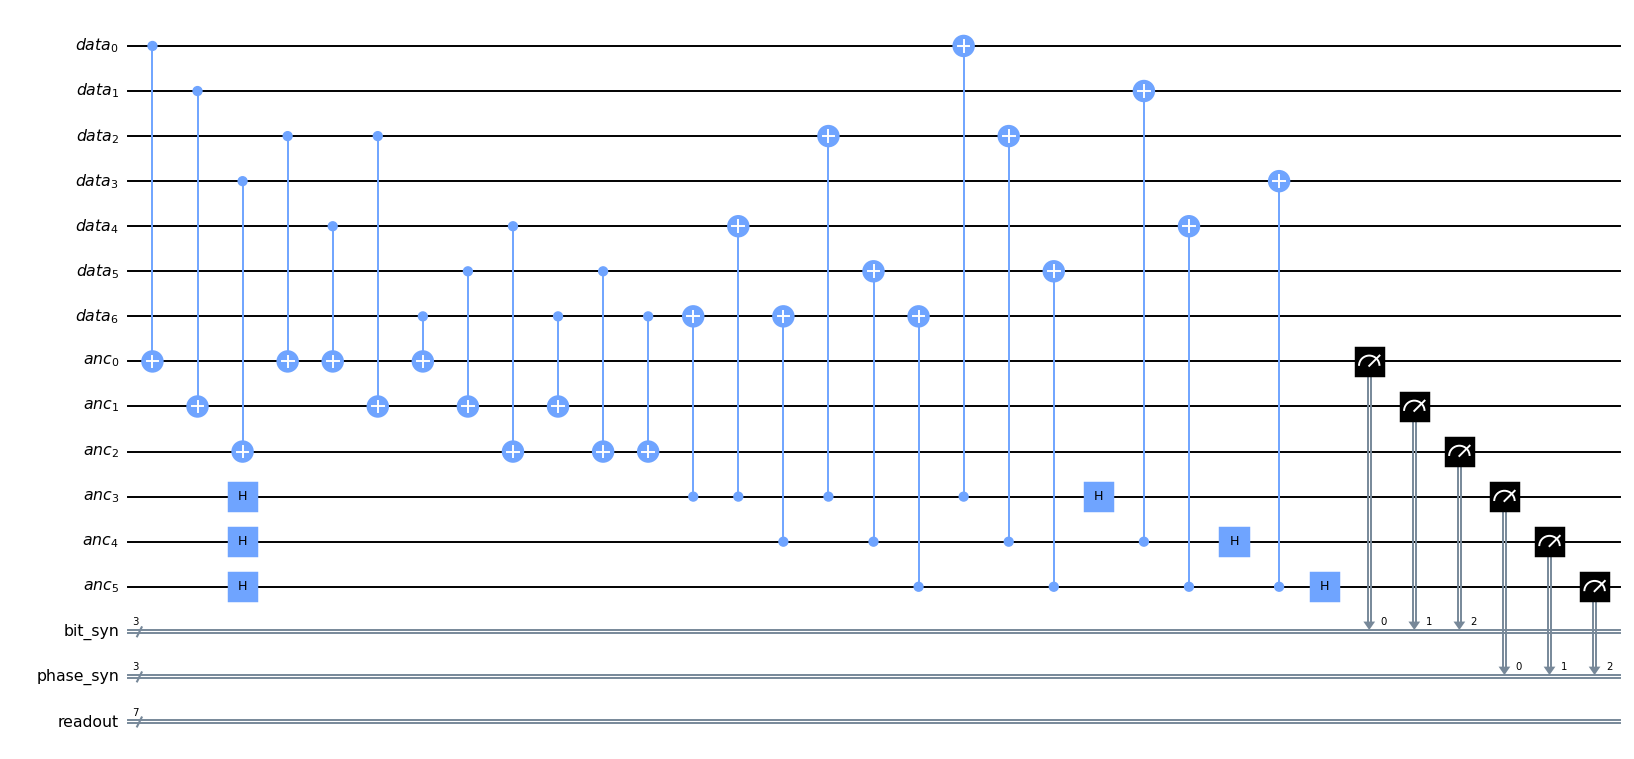

In [5]:
circuit = QuantumCircuit(qdata_register, stabilizer_measure_reg, bit_syndrome_measure, phase_syndrome_measure, cdata_register)
# circuit.append(encoding(), qdata_register)
circuit.append(stabilizer_measurement(), [*qdata_register, *stabilizer_measure_reg], [*bit_syndrome_measure, *phase_syndrome_measure])
circuit.decompose().draw("mpl", scale=0.7, fold=60, plot_barriers=False)

In [6]:
def build_error_correction_sequence(noisy_qubits, apply_correction = False, apply_fake_noise = None, code_distance = 3) -> QuantumCircuit:
    '''Build the error correction sequence'''    
    circuit = QuantumCircuit(qdata_register, stabilizer_measure_reg, bit_syndrome_measure, phase_syndrome_measure, cdata_register)
    circuit = initialize_qubits(circuit, qdata_register[0])

    circuit.append(encoding(), qdata_register)
    circuit.barrier()
    
    if apply_fake_noise is not None:
        noise_type = apply_fake_noise
        circuit = fake_noise(circuit, qdata_register, code_distance, noise_type, noisy_qubits)
        circuit.barrier()

    circuit.append(stabilizer_measurement(), [*qdata_register, *stabilizer_measure_reg], [*bit_syndrome_measure, *phase_syndrome_measure])

    if apply_correction:
        circuit = recovery(circuit, qdata_register, bit_syndrome_measure, phase_syndrome_measure)
    else:
        circuit.id(qdata_register)
        circuit.id(qdata_register)
        
    circuit.barrier()
    
    circuit.append(decoding(), qdata_register)

    circuit = final_readout(circuit, qdata_register, cdata_register)

    return circuit

/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py:1807: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


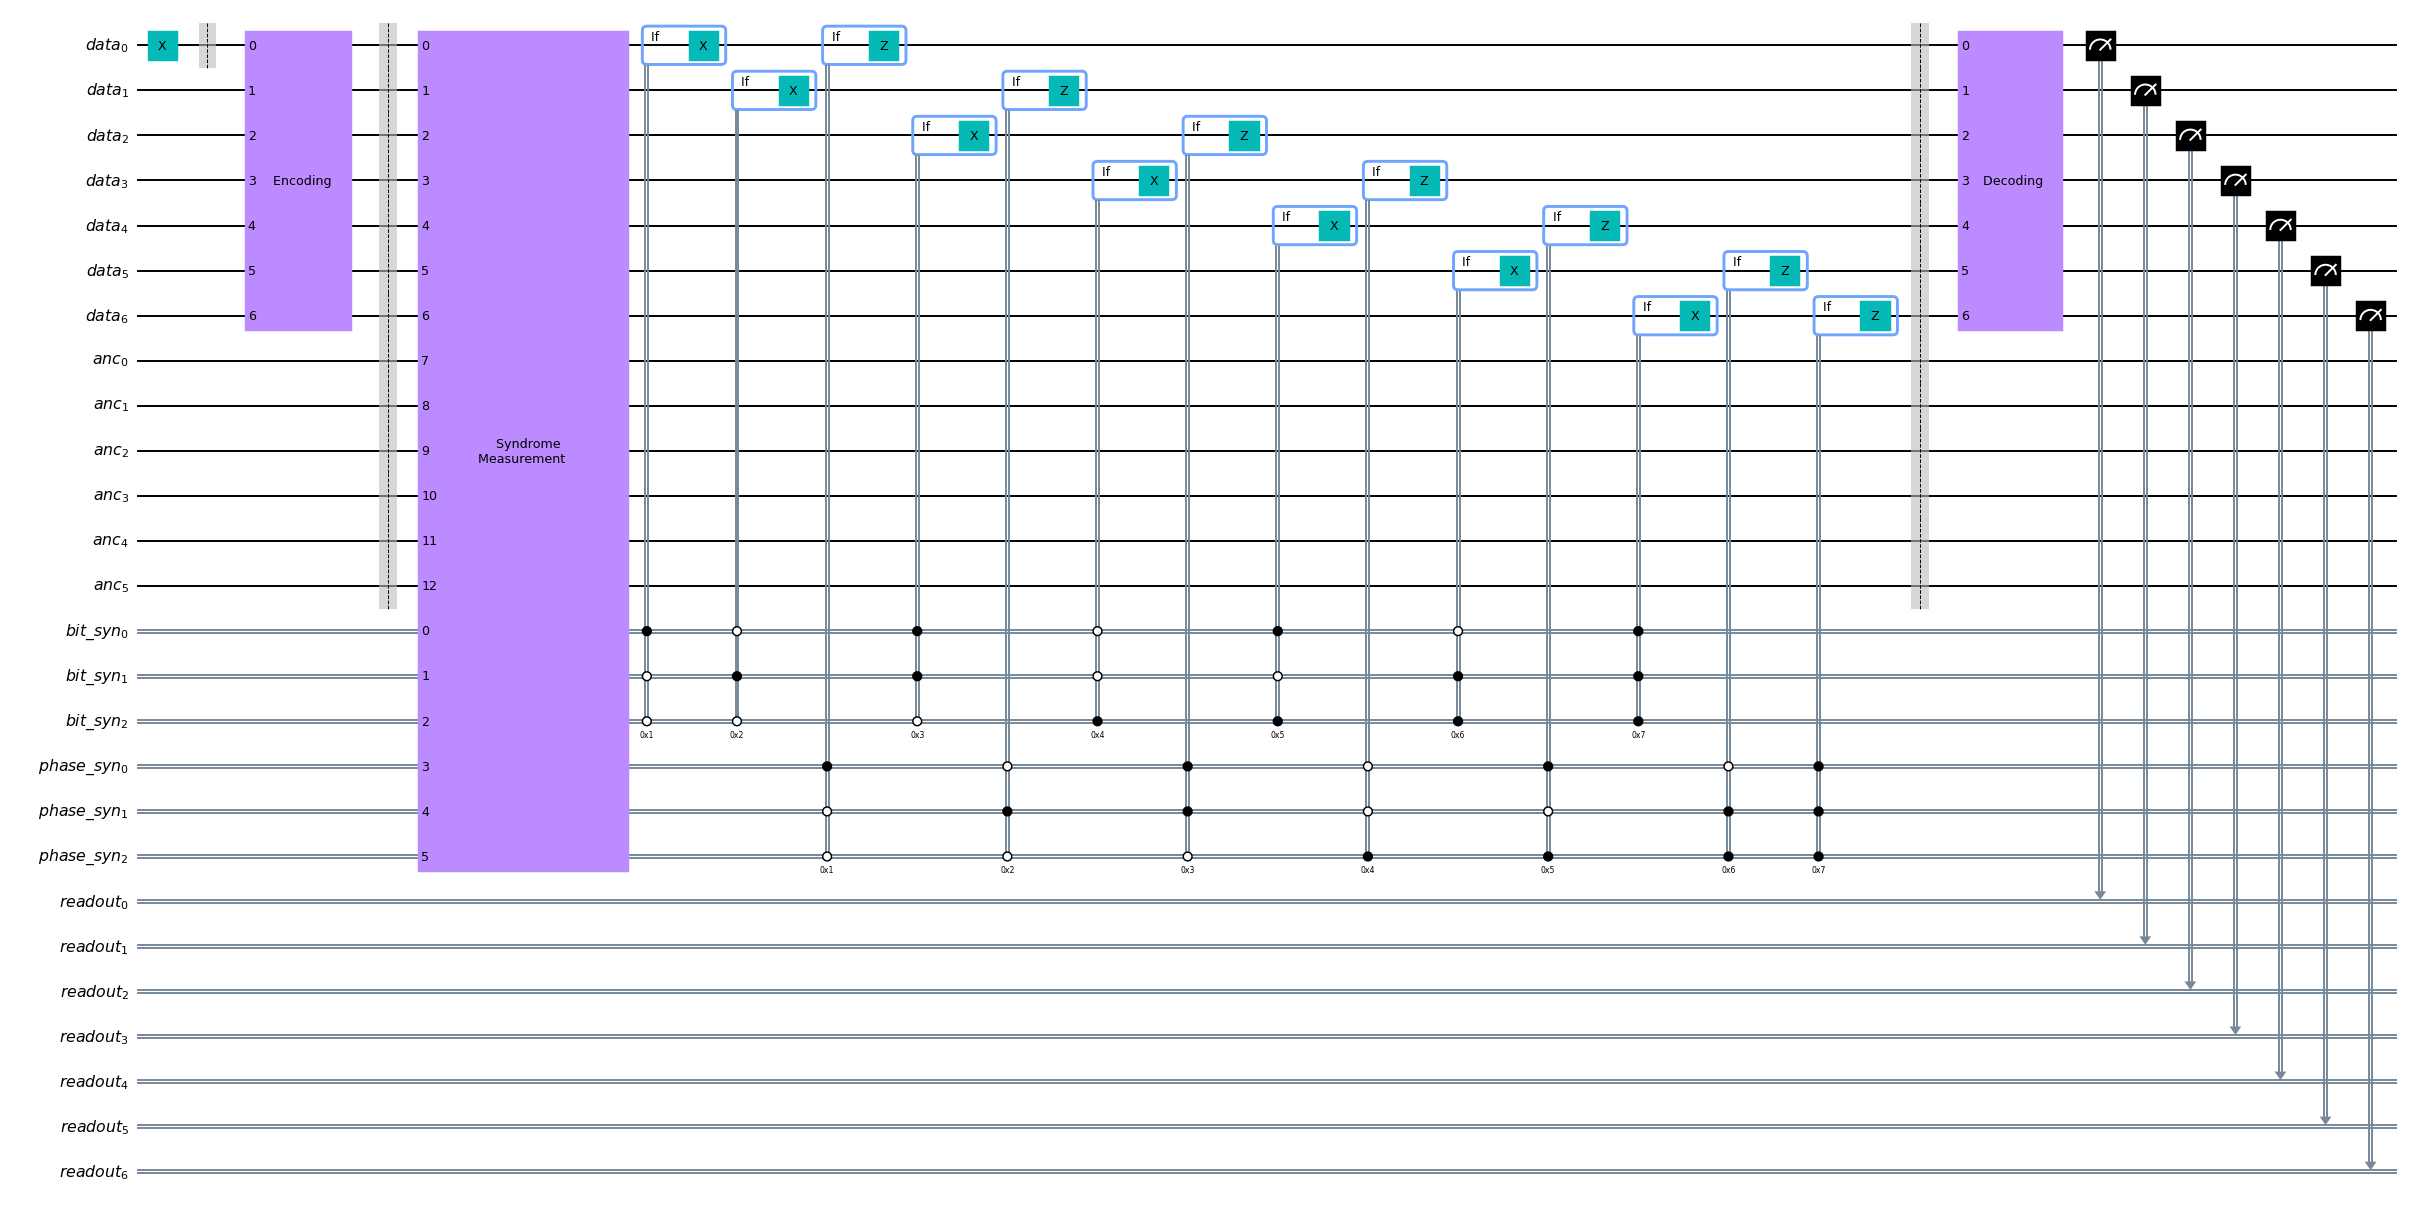

In [7]:
noisy_qubits = np.random.randint(len(qdata_register), size=(3 - 1)//2)
noise_ = None

circuit_with_correction = build_error_correction_sequence(noisy_qubits, apply_correction = True, apply_fake_noise= noise_)
circuit_without_correction = build_error_correction_sequence(noisy_qubits, apply_correction = False, apply_fake_noise= noise_)

circuit_with_correction.draw("mpl", plot_barriers=True, scale = 0.7, fold=60, cregbundle=True)

In [8]:
# circuit_with_correction.decompose().draw("mpl", scale=0.7, fold=60, plot_barriers=True)

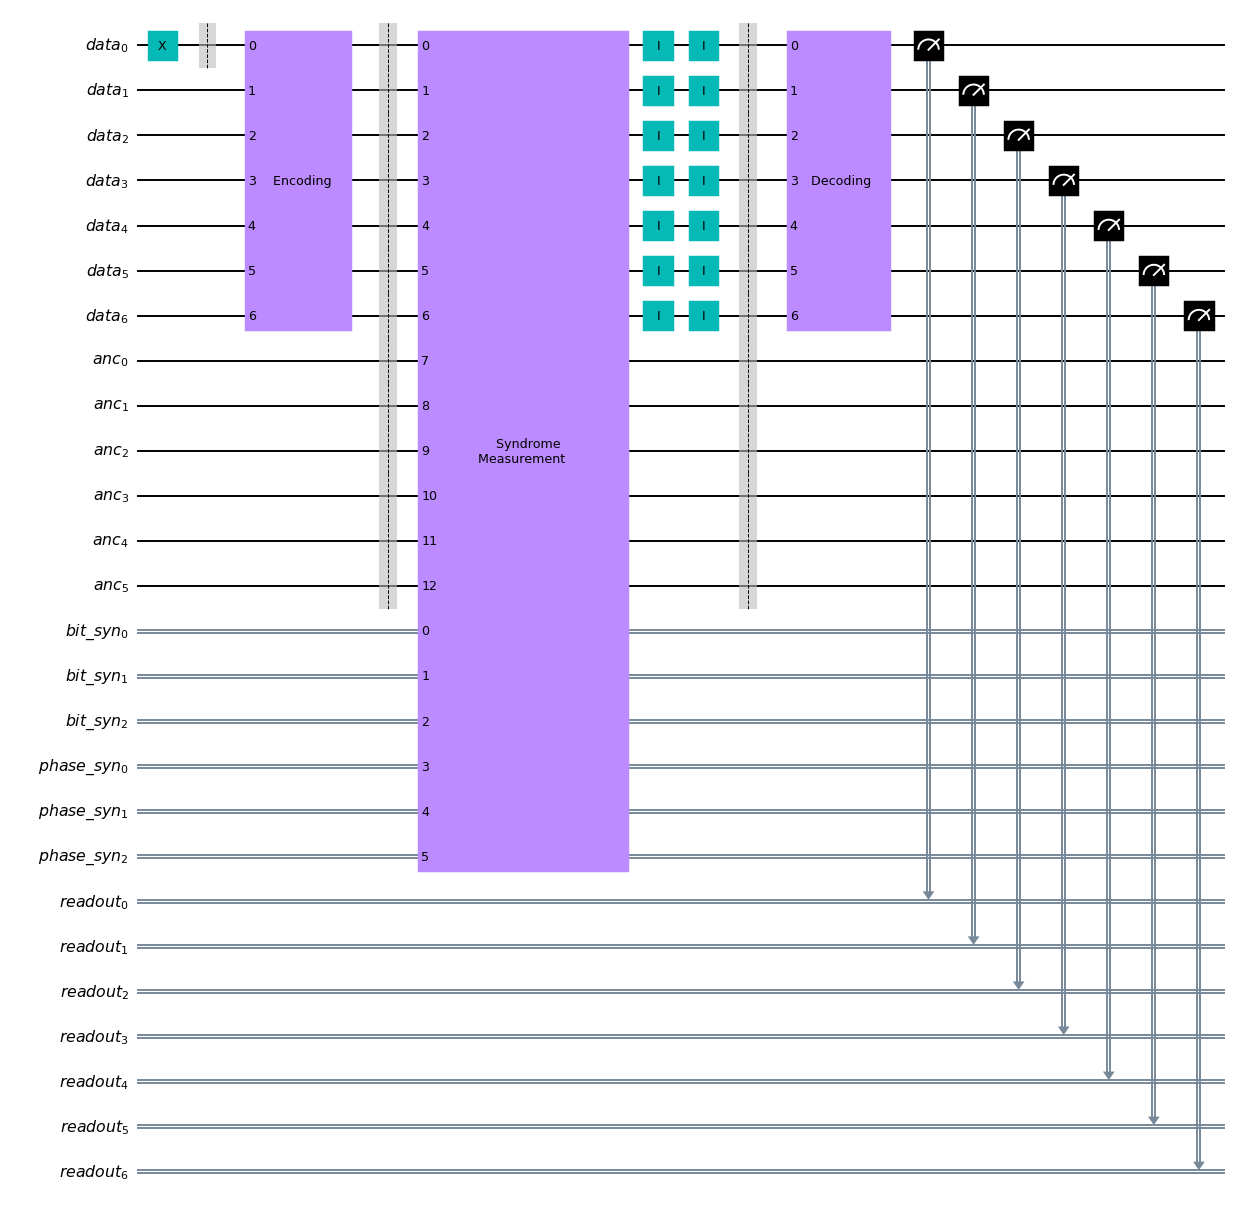

In [9]:
circuit_without_correction.draw("mpl", scale=0.7, fold=60, plot_barriers=True)

In [10]:
shots = 1024
# provider = IBMProvider()
# provider.backends()

In [11]:
# backend = least_busy(provider.backends(simulator=False, operational=True, dynamic_circuits = True))
# # provider.get_backend("ibmq_qasm_simulator")
# backend = provider.get_backend("ibm_brisbane")
# backend

In [13]:
import qiskit_aer.noise as noise
from qiskit.providers.fake_provider import FakeMontreal

backend = FakeMontreal()
noise_model = noise.NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# p_reset = 0.003
# p_meas = 0.01
# p_gate1 = 0.005

# # QuantumError objects
# error_reset = noise.pauli_error([('X', p_reset), ('I', 1 - p_reset)])
# error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
# error_gate1 = noise.pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

# # Add errors to noise model
# noise_bit_flip = noise.NoiseModel()
# noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
# noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
# noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["id"])

# noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# noise_model = noise.NoiseModel()
# error = noise.depolarizing_error(0.05, 1)
# noise_model.add_all_qubit_quantum_error(error, ["id"])

# Perform a noise simulation
# backend = AerSimulator(noise_model=noise_model,
#                        coupling_map=coupling_map,
#                        basis_gates=basis_gates)

# backend = AerSimulator(noise_model=noise_model)
backend = AerSimulator()

# print(noise_model)
backend

AerSimulator('aer_simulator')

In [14]:
correction_transpiled_circuit = transpile(circuit_with_correction, backend)
uncorrected_transpiled_circuit = transpile(circuit_without_correction, backend)
# correction_transpiled_circuit.draw(output="mpl", idle_wires=False, scale=0.5, fold=50)

/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


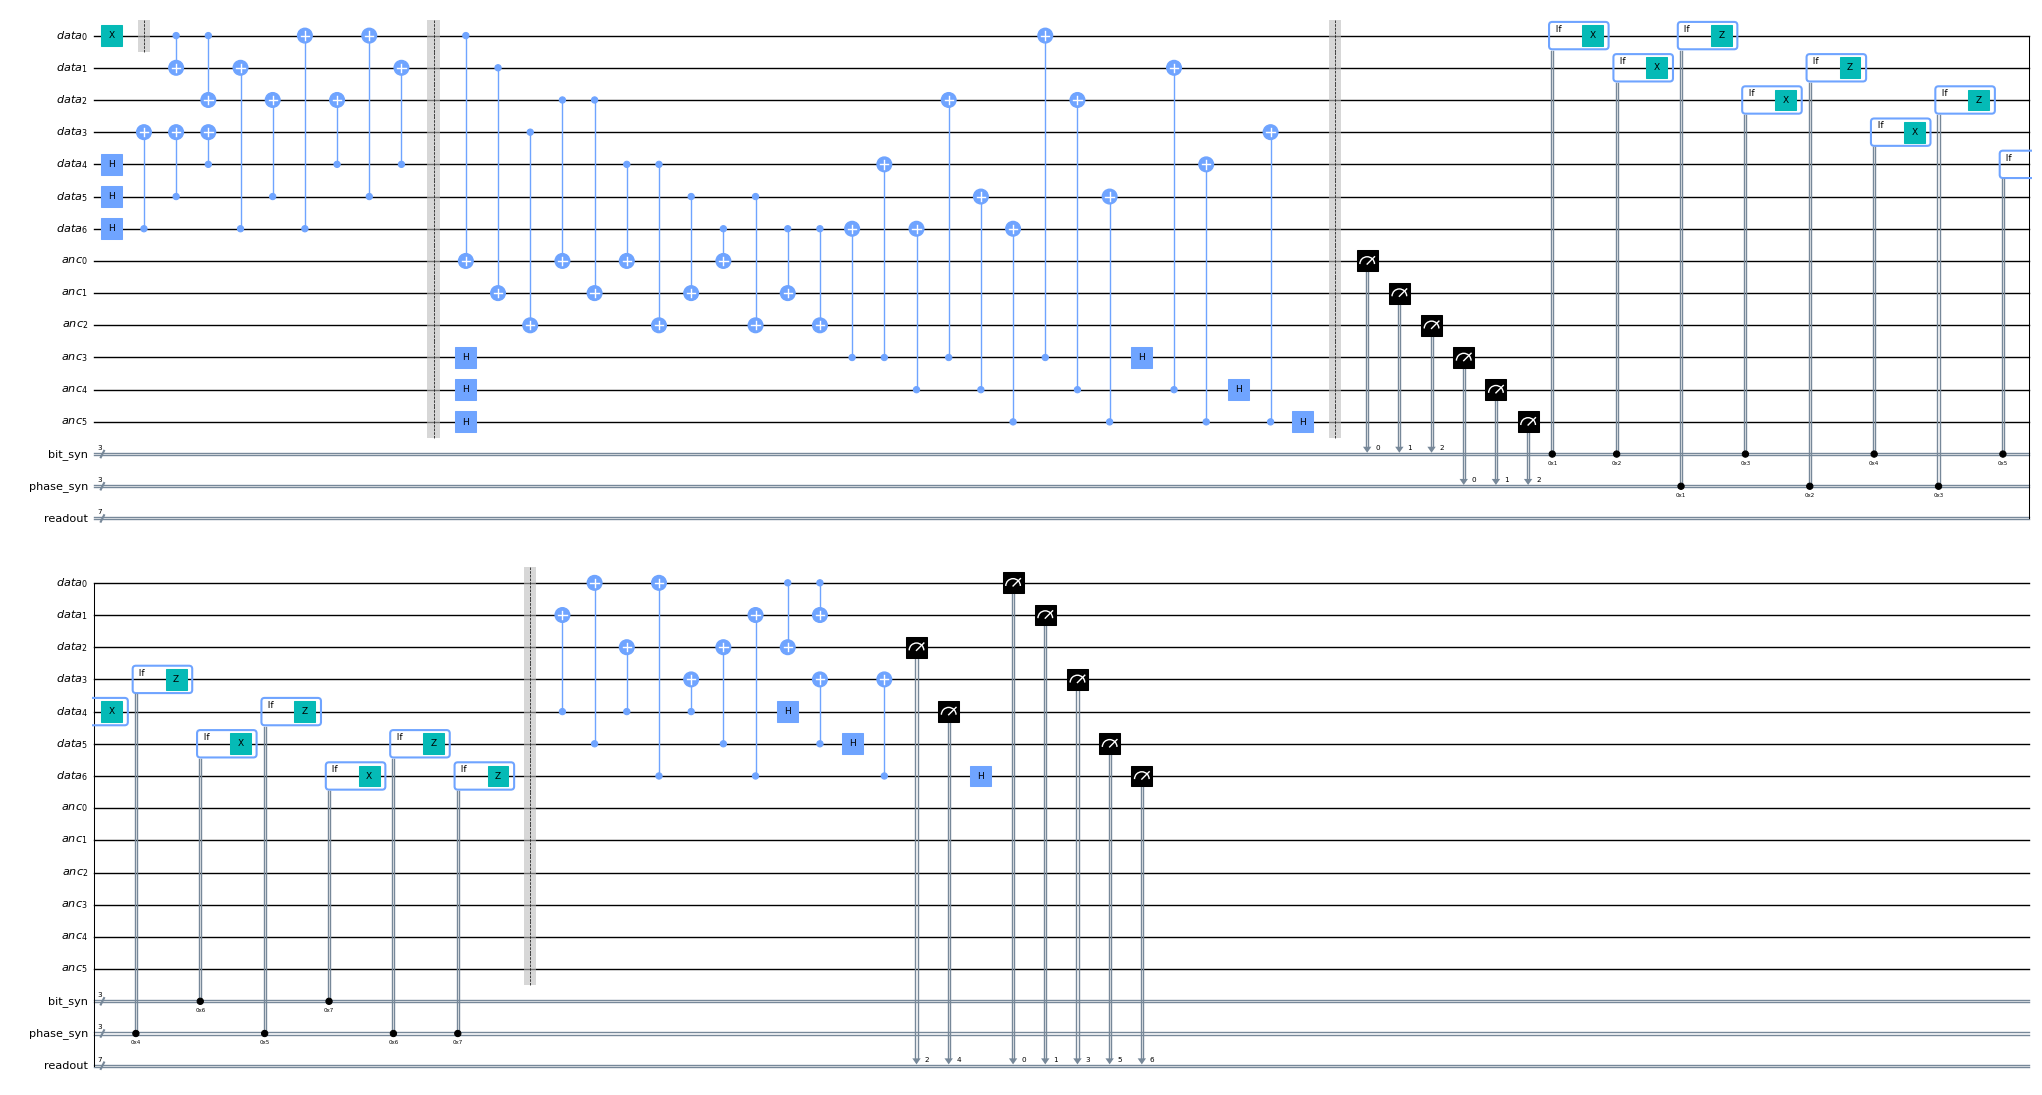

In [15]:
correction_transpiled_circuit.draw(output="mpl", scale=0.5, idle_wires=False, fold=60)

In [16]:
correction_transpiled_circuit.depth()

35

In [17]:
# job_with_correction = backend.run(correction_transpiled_circuit, shots=shots, dynamic=True)
# job_monitor(job_with_correction)

In [18]:
import json
from qiskit.result import Result

f = open('./7_1_3_job_results/cnwn6ht418100080aj70-result.txt')
correction_data = json.load(f)

result_with_correction = Result.from_dict(correction_data)
# result.get_counts()

In [19]:
# result_with_correction = job_with_correction.result()

In [20]:
# job_without_correction = backend.run(uncorrected_transpiled_circuit, shots=shots, dynamic = True)
# job_monitor(job_without_correction)

In [21]:
# result_without_correction = job_without_correction.result()

In [22]:
f = open('./7_1_3/cnx8d2wsdyyg0080kegg-result.txt')
correction_data = json.load(f)

result_without_correction = Result.from_dict(correction_data)

In [23]:
# initial_state = ['0000001', '0000000']
# ideal_result = {'0000001': shots//2, '0000000': shots//2}

initial_state = ['0000001']
ideal_result = {'0000001': shots}

In [24]:
# result_with_correction.get_counts()

In [25]:
# result_without_correction.get_counts()

In [26]:
bit_syndrome_indices = list(range(len(bit_syndrome_measure)))
phase_syndrome_indices = list(range(bit_syndrome_indices[-1] + 1, len(bit_syndrome_measure) + len(phase_syndrome_measure)))
data_indices = list(range(phase_syndrome_indices[-1]+1, len(qdata_register) + len(bit_syndrome_measure) + len(phase_syndrome_measure)))

print(bit_syndrome_indices, phase_syndrome_indices, data_indices)

def decode_result(data_counts, bit_syndrome_counts, phase_syndrome_counts, initial_state):
    shots = sum(data_counts.values())
    success_trials = sum([data_counts.get(i, 0) for i in initial_state])
    failed_trials = shots - success_trials
    bit_error_correction_events = shots - bit_syndrome_counts.get('000', 0)
    phase_error_correction_events = shots - phase_syndrome_counts.get('000', 0)
    print(f"Bit-flip errors were detected/corrected on {bit_error_correction_events}/{shots} trials")
    print(f"Phase-flip errors were detected/corrected on {phase_error_correction_events}/{shots} trials")
    print(f"A final error was detected on {failed_trials}/{shots} trials")

[0, 1, 2] [3, 4, 5] [6, 7, 8, 9, 10, 11, 12]


In [27]:
syndrome_indices = bit_syndrome_indices + phase_syndrome_indices
syndrome_indices

[0, 1, 2, 3, 4, 5]

In [28]:
print("******************** Without Quantum Error Correction ********************\n")

non_corrected_marginalized_data_counts = marginal_counts(result_without_correction, data_indices).get_counts(0)
non_bit_corrected_marginalized_syndrome_counts = marginal_counts(result_without_correction, bit_syndrome_indices).get_counts(0)
non_phase_corrected_marginalized_syndrome_counts = marginal_counts(result_without_correction, phase_syndrome_indices).get_counts(0)

print(f'Completed code experiment data measurement counts {non_corrected_marginalized_data_counts}')
print(f'Completed bit experiment syndrome measurement counts {non_bit_corrected_marginalized_syndrome_counts}')
print(f'Completed phase experiment syndrome measurement counts {non_phase_corrected_marginalized_syndrome_counts}')
decode_result(non_corrected_marginalized_data_counts, non_bit_corrected_marginalized_syndrome_counts, non_phase_corrected_marginalized_syndrome_counts, initial_state)

print("\nFidelity: {}".format(hellinger_fidelity(ideal_result, non_corrected_marginalized_data_counts)))

******************** Without Quantum Error Correction ********************

Completed code experiment data measurement counts {'1000000': 13, '1000001': 7, '0000100': 9, '1000010': 7, '1000011': 10, '0000000': 7, '1000100': 15, '1000101': 11, '1000110': 5, '1000111': 5, '1001000': 9, '1001001': 9, '1001010': 7, '1001011': 9, '1001100': 9, '1001101': 4, '1001110': 7, '1001111': 8, '1010000': 11, '1010001': 7, '1010010': 7, '1010011': 8, '1010100': 6, '1010101': 14, '0000101': 7, '1010110': 4, '1010111': 11, '1011000': 7, '1011001': 12, '1011010': 13, '1011011': 7, '1011100': 11, '1011101': 9, '1011110': 10, '1011111': 15, '1100000': 7, '1100001': 6, '0000110': 4, '1100010': 7, '1100011': 4, '1100100': 5, '1100101': 13, '1100110': 3, '1100111': 5, '1101000': 9, '1101001': 11, '1101010': 7, '1101011': 8, '1101100': 6, '1101101': 7, '1101110': 12, '1101111': 2, '1110000': 4, '0000111': 8, '1110001': 11, '1110010': 5, '1110011': 7, '1110100': 4, '1110101': 5, '1110110': 13, '1110111': 8, '1

In [29]:
print("******************** With Quantum Error Correction ********************\n")

corrected_marginalized_data_counts = marginal_counts(result_with_correction, data_indices).get_counts(0)
corrected_bit_marginalized_syndrome_counts = marginal_counts(result_with_correction, bit_syndrome_indices).get_counts(0)
corrected_phase_marginalized_syndrome_counts = marginal_counts(result_with_correction, phase_syndrome_indices).get_counts(0)

print(f'Completed code experiment data measurement counts {corrected_marginalized_data_counts}')
print(f'Completed bit experiment syndrome measurement counts {corrected_bit_marginalized_syndrome_counts}')
print(f'Completed phase experiment syndrome measurement counts {corrected_phase_marginalized_syndrome_counts}')
decode_result(corrected_marginalized_data_counts, corrected_bit_marginalized_syndrome_counts, corrected_phase_marginalized_syndrome_counts, initial_state)

print("\nFidelity: {}".format(hellinger_fidelity(ideal_result, corrected_marginalized_data_counts)))

******************** With Quantum Error Correction ********************

Completed code experiment data measurement counts {'0000100': 6, '1000000': 3, '1000001': 10, '1000010': 8, '1000011': 9, '1000100': 9, '1000101': 13, '1000110': 3, '1000111': 6, '1001000': 9, '1001001': 9, '1001010': 3, '1001011': 8, '1001100': 8, '1001101': 4, '1001110': 5, '1001111': 8, '1010000': 9, '1010001': 7, '0000101': 12, '1010010': 7, '1010011': 5, '1010100': 9, '1010101': 9, '1010110': 8, '1010111': 9, '1011000': 5, '1011001': 9, '1011010': 12, '1011011': 11, '0000000': 9, '1011100': 6, '1011101': 11, '1011110': 7, '1011111': 11, '1100000': 7, '0000110': 5, '1100001': 11, '1100010': 14, '1100011': 10, '1100100': 5, '1100101': 5, '1100110': 7, '1100111': 6, '1101000': 11, '1101001': 9, '1101010': 4, '1101011': 4, '1101100': 9, '1101101': 7, '1101110': 5, '1101111': 11, '0000111': 13, '1110000': 10, '1110001': 7, '1110010': 8, '1110011': 4, '1110100': 7, '1110101': 6, '1110110': 13, '1110111': 10, '11110